In [1]:
ROOT="/home/sl1471/workspace/experiments/"
best_setting = {'amz_Movies_and_TV': {'MF': ['/logs/f2rec_train_and_eval_MF_lr0.0001_reg1.0_losspairwisebpr.log'], 
                                      'FedMF': ['/logs/f2rec_train_and_eval_FedMF_lr0.003_reg1.0_losspairwisebpr_local1_fedavg.log'], 
                                      'FairMF': ['/logs/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda0.1_gactivity.log',
                                                 '/logs/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda1.0_gactivity.log',
                                                 '/logs/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda0._gactivity.log'],
                                      'F2MF': []
#                                       'F2MF': ['/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda0.1_gactivity.log',
#                                                '/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda1.0_gactivity.log',
#                                                '/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda0._gactivity.log']
                                     },
                'amz_Books': {'MF': ['/logs/f2rec_train_and_eval_MF_lr0.00001_reg1.0_losspairwisebpr.log'], 
                              'FedMF': [],
#                               'FedMF': ['/logs/f2rec_train_and_eval_MF_lr0.003_reg1.0_losspairwisebpr_local1_fedavg.log'], 
                              'FairMF': ['/logs/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda0.1_gactivity.log',
                                         '/logs/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda1.0_gactivity.log',
                                         '/logs/f2rec_FairMF_lr0.00001_reg1.0_pairwisebpr_lambda0._gactivity.log'],
                              'F2MF': []
#                               'F2MF': ['/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda0.1_gactivity.log',
#                                        '/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda1.0_gactivity.log',
#                                        '/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda0._gactivity.log']
                             },
                'ml-1m': {'MF': ['/logs/f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log'], 
                          'FedMF': ['/logs/f2rec_train_and_eval_MF_lr0.003_reg0.1_losspairwisebpr_local1_fedavg.log'], 
                          'FairMF': ['/logs/f2rec_FairMF_lr0.00001_reg0.1_pairwisebpr_lambda0.1_gactivity.log',
                                     '/logs/f2rec_FairMF_lr0.00001_reg0.1_pairwisebpr_lambda1.0_gactivity.log',
                                     '/logs/f2rec_FairMF_lr0.00001_reg0.1_pairwisebpr_lambda0._gactivity.log'],
                          'F2MF': []
#                               'F2MF': ['/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda0.1_gactivity.log',
#                                        '/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda1.0_gactivity.log',
#                                        '/logs/f2rec_FairFedMF_lr0.001_reg1.0_pairwisebpr_lambda0._gactivity.log']}
                         }
               }

In [2]:
data_key_list = ['ml-1m','amz_Movies_and_TV','amz_Books']
model_name_list = ['MF','FedMF','FairMF','F2MF']
group_feature = 'activity'
# lambda_choices = ['0.1', '1.0', '0.']

In [3]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import argparse
from argparse import Namespace

def read_line_number(file_path, line_num):
    with open(file_path, 'r') as fin:
        for i,line in enumerate(fin):
            if i == line_num:
                return line.strip()
    return ""

def extract_args(log_path):
    print(log_path)
    argstr = read_line_number(log_path, 1)
    if 'fair_lambda' not in argstr:
        argstr = argstr[:-1] + ', fair_lambda=0.1)'
    if 'fair_rho' not in argstr:
        argstr = argstr[:-1] + ', fair_rho=1)'
    if 'fair_group_feature' not in argstr:
        argstr = argstr[:-1] + f", fair_group_feature='{group_feature}')"
    args = eval(argstr)
    return args

## Do Fairness Evaluation

In [4]:
from reader.RecDataReader import RecDataReader
from model.fair_rec.FairUserGroupPerformance import FairUserGroupPerformance
from model.baselines import *
from model.fed_rec import *
import os
import torch

model_definition = {'MF': 'MF', 'FedMF': 'FedMF', 'FairMF': 'MF', 'F2MF': 'FedMF'}
device = -1
if device >= 0 and torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
    torch.cuda.set_device(device)
    device = "cuda:" + str(device)
else:
    device = "cpu"
params = {'at_k_list': [10,50], 'eval_sample_p': 1.0}

In [5]:
from reader.BaseReader import worker_init_func
from task.TopK import init_ranking_report, calculate_ranking_metric

def get_userwise_group(model, group_feature, fairness_control):
    eval_data = model.reader.get_eval_dataset()
    eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                             batch_size = 1, shuffle = False, pin_memory = False, 
                             num_workers = eval_data.n_worker)
    user_groups = {}
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loader):
            # sample user with record in eval data
            if "no_item" not in batch_data:
                # predict
                feed_dict = model.wrap_batch(batch_data)
                uid = feed_dict["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
                user_groups[uid] = fairness_control.group_dict[uid]
    return user_groups

def get_userwise_performance(model, at_k_list):
    model.reader.set_phase('test')
    eval_data = model.reader.get_eval_dataset()
    eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                             batch_size = 1, shuffle = False, pin_memory = False, 
                             num_workers = eval_data.n_worker)
    user_results = {}
    with torch.no_grad():
        for i, batch_data in enumerate(eval_loader):
            # sample user with record in eval data
            if "no_item" not in batch_data:
                # predict
                feed_dict = model.wrap_batch(batch_data)
                out_dict = model.forward(feed_dict, return_prob = True)
                pos_preds, neg_preds = out_dict["probs"], out_dict["neg_probs"]
                if pos_preds.is_cuda:
                    pos_preds = pos_preds.detach().cpu()
                    neg_preds = neg_preds.detach().cpu()
                # metrics
                report = init_ranking_report(at_k_list)
                calculate_ranking_metric(pos_preds.view(-1), neg_preds.view(-1), at_k_list, report)
                uid = feed_dict["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
                user_results[uid] = report
    return user_results

In [ ]:
import os
import datetime
from torch.utils.data import DataLoader
import torch
import numpy as np

metrics = ['F1@10','NDCG@10','F1@50','NDCG@50','AUC']
for data_key in data_key_list:
    result_file_path = ROOT + data_key + "/results/fairness_" + group_feature + "_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".csv"
    with open(result_file_path, 'w') as fout:
        count = 0
        for modelName in model_name_list:
            log_path_list = best_setting[data_key][modelName]
            for log_path in log_path_list:
                # args
                try:
                    args = extract_args(ROOT + data_key + log_path)
                    print(args)
                except:
                    print('skip')
                    continue
                # reader
                reader = RecDataReader(args)
                # fairness calculator
                fairness_controller = FairUserGroupPerformance(args, reader)
                # model
                modelClass = eval('{0}.{0}'.format(model_definition[modelName]))
                model = modelClass(args, reader, device)
                model.load_from_checkpoint(args.model_path, with_optimizer = False)
                model = model.to(device)
                model.device = device
                # header
                if count == 0:
                    uG = get_userwise_group(model, group_feature, fairness_controller)
                    fout.write('\t'.join(['model','fair_group','fair_lambda','metric'] + [str(uid) for uid in uG.keys()]) + '\n')
                    fout.write('\t'.join(['all','-','-','group'] + list(uG.values())) + '\n')
                count += 1
                # evaluation
                user_results = get_userwise_performance(model, params['at_k_list'])
                for m in metrics:
                    fout.write('\t'.join([modelName,args.fair_group_feature,str(args.fair_lambda),m] + [str(user_results[uid][m]) for uid in uG]) + '\n')

/home/sl1471/workspace/experiments/ml-1m/logs/f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log
Namespace(cuda=3, seed=19, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_MF_lr0.0001_reg0.1_pairwisebpr.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.vocab', n_neg=1, n_neg_val=100, n_neg_test=-1,

100%|██████████| 6023/6023 [00:08<00:00, 747.91it/s]


user activity: 1885(A) -- 4138(I), threshold (133.05495600199237)
embedding: tensor([[-0.0031,  0.0135, -0.0171,  ...,  0.0143, -0.0286,  0.0194],
        [-0.0005, -0.0285, -0.0269,  ..., -0.0304,  0.0085, -0.0188],
        [ 0.0186, -0.0176, -0.0086,  ..., -0.0237, -0.0413, -0.0120],
        ...,
        [ 0.0247, -0.0340, -0.0128,  ...,  0.0240, -0.0077,  0.0231],
        [ 0.0156,  0.0001,  0.0261,  ...,  0.0321, -0.0230,  0.0021],
        [-0.0136,  0.0220,  0.0030,  ..., -0.0012, -0.0363, -0.0214]])
embedding: tensor([[ 0.0227, -0.0180, -0.0008,  ...,  0.0077, -0.0198, -0.0088],
        [ 0.0176,  0.0247, -0.0606,  ..., -0.0043,  0.0018, -0.0227],
        [ 0.0231,  0.0075,  0.0326,  ..., -0.0550, -0.0174, -0.0324],
        ...,
        [ 0.0011, -0.0298,  0.0092,  ..., -0.0006,  0.0056,  0.0133],
        [-0.0135,  0.0489, -0.0287,  ..., -0.0102,  0.0040,  0.0167],
        [-0.0185, -0.0105,  0.0019,  ..., -0.0041, -0.0023,  0.0184]])
Load (checkpoint) from /home/sl1471/workspac

 84%|████████▍ | 5050/6022 [04:00<00:54, 17.88it/s]

In [14]:
file_path = ROOT + data_key + "/results/fairness_activity_20220110_160353.csv"
with open(file_path, 'r') as fin:
    header = fin.readline().strip().split('\t')
    result_dict = {i: [h] for i,h in enumerate(header)}
    for line in fin:
        row = line.strip().split('\t')
        for i,v in enumerate(row):
            result_dict[i].append(v)

In [17]:
import pandas as pd
df = pd.DataFrame.from_dict(result_dict,orient='index')
df[:10]

,0,1,2,3,4,5,6
0,model,all,MF,MF,MF,MF,MF
1,fair_group,-,activity,activity,activity,activity,activity
2,fair_lambda,-,0.1,0.1,0.1,0.1,0.1
3,metric,group,F1@10,NDCG@10,F1@50,NDCG@50,AUC
4,4,inactive,0.0,0.0,0.03846153989434242,0.12262944132089615,0.9769192587690272
5,1,inactive,0.0,0.0,0.0,0.0,0.7534448160535117
6,2,inactive,0.0,0.0,0.032258063554763794,0.037980806082487106,0.7050160146419584
7,3,inactive,0.0,0.0,0.036363635212183,0.060093700885772705,0.9030748663101604
8,8,inactive,0.0,0.0,0.0317460335791111,0.04904395714402199,0.6569188387370206
9,5,active,0.0,0.0,0.0,0.0,0.766235927014586


In [40]:
import numpy as np
from tqdm import tqdm
groups = np.unique(df[1].values[4:])
group_metrics = {G: {m: 0 for m in metrics} for G in groups}
for G in tqdm(groups):
    subset = df.loc[df[1] == G]
    for i,m in enumerate(metrics):
#         print(i,m)
#         print(subset[i+2].values)
        group_metrics[G][m] = np.mean([float(v) for v in subset[i+2].values])
print(group_metrics)

100%|██████████| 2/2 [00:00<00:00, 83.44it/s]

{'active': {'F1@10': 0.04682209551759282, 'NDCG@10': 0.11651660633182019, 'F1@50': 0.08715339434340556, 'NDCG@50': 0.11419214135732511, 'AUC': 0.7771681834277132}, 'inactive': {'F1@10': 0.02988326041298498, 'NDCG@10': 0.041240877963752025, 'F1@50': 0.0332892626786912, 'NDCG@50': 0.08389750800140748, 'AUC': 0.827906453579597}}


In [47]:
def get_diff(groupwise_performance):
    S,C = 0,0
    for i,v0 in enumerate(groupwise_performance):
        for v1 in groupwise_performance[i+1:]:
            S += abs(v0-v1)
            C += 1
    return S/C, S, C

for m in metrics:
    groupwise_performance = [group_metrics[G][m] for G in groups]
    print(f"{m}\t: {get_diff(groupwise_performance)}\t {groupwise_performance}")

F1@10	: (0.016938835104607836, 0.016938835104607836, 1)	 [0.04682209551759282, 0.02988326041298498]
NDCG@10	: (0.07527572836806817, 0.07527572836806817, 1)	 [0.11651660633182019, 0.041240877963752025]
F1@50	: (0.05386413166471436, 0.05386413166471436, 1)	 [0.08715339434340556, 0.0332892626786912]
NDCG@50	: (0.03029463335591763, 0.03029463335591763, 1)	 [0.11419214135732511, 0.08389750800140748]
AUC	: (0.05073827015188381, 0.05073827015188381, 1)	 [0.7771681834277132, 0.827906453579597]


In [39]:
np.sum(df.loc[df[1]=='active'][3].values)

'0.00.129875004291534420.41528072953224180.00.085143111646175380.248908311128616330.085143111646175380.00.094788365066051480.39375844597816470.00.00.00.138862445950508120.00.00.00.00.00.00.00.078398264944553380.34527835249900820.00.00.00.00.138862445950508120.085143111646175380.00.078398264944553380.00.085143111646175380.00.00.381134361028671260.00.00.00.00.44221955537796020.39327839016914370.179477095603942870.488349139690399170.23365081846714020.00.212226361036300660.135685443878173830.30523484945297240.00.00.41628450155258180.40731742978096010.078398264944553380.358954191207885740.085143111646175380.220091760158538820.00.00.069431222975254060.00.18844413757324220.293455690145492550.00.14279514551162720.085143111646175380.00.00.00.64640176296234130.00.55414313077926640.00.248908311128616330.163541376590728760.53525424003601070.00.55480104684829710.069431222975254060.154574334621429440.00.00.716287374496460.00.00.00.00.22212779521942140.073363922536373140.00.168152287602424620.00.1517

## Data Reader

In [68]:
# from reader.FedRecReader import FedRecReader
# reader = FedRecReader(args)
from reader.RecDataReader import RecDataReader
reader = RecDataReader(args)

Loading train data file. Done.
Loading val data file. Done.
Loading test data file. Done.
           UserID      ItemID  Response   Timestamp
0  A100WO06OQR8BQ  B005NKIPWC       3.0  1382140800
1  A100WO06OQR8BQ  079284209X       1.0  1383436800
2  A100WO06OQR8BQ  B00151QYE4       1.0  1384905600
3  A100WO06OQR8BQ  B00151QYE4       1.0  1384905600
4  A100WO06OQR8BQ  B00EK6RM92       5.0  1386460800
Load field meta and vocab file.
Load vocab from : /home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/user_fields.vocab
User fields: ['UserID']
Load vocab from : /home/sl1471/workspace/experiments/amz_Movies_and_TV/meta_data/item_fields.vocab
Item fields: ['ItemID', 'Category', 'MinPrice', 'MaxPrice', 'Brand']
Appending history info
Buffer negative training and validation samples


100%|██████████| 5498/5498 [00:38<00:00, 142.73it/s]


In [69]:
from model.fair_rec.FairUserGroupPerformance import get_user_group_info

# group_feature = 'AgeGroup'
group_feature = 'activity'
group_dict, feature_values = get_user_group_info(reader, group_feature)

user activity: 1335(A) -- 4163(I), threshold (71.07984721716988)


## Model

In [70]:
from model.baselines import *
from model.fed_rec import *

device = 'cpu'
modelClass = eval('{0}.{0}'.format(modelName))
model = modelClass(args, reader, device)
model.load_from_checkpoint(args.model_path, with_optimizer = False)
model = model.to(device)
model.device = device

embedding: tensor([[ 0.0075, -0.0186,  0.0074,  ..., -0.0086,  0.0037, -0.0109],
        [ 0.0399,  0.0145,  0.0014,  ...,  0.0291,  0.0461,  0.0122],
        [-0.0013,  0.0123,  0.0115,  ...,  0.0168,  0.0106,  0.0246],
        ...,
        [-0.0040, -0.0034, -0.0375,  ...,  0.0138, -0.0121,  0.0093],
        [ 0.0149,  0.0091, -0.0289,  ...,  0.0067,  0.0245, -0.0017],
        [ 0.0038, -0.0336,  0.0039,  ...,  0.0125,  0.0003,  0.0053]])
embedding: tensor([[ 1.1879e-02, -6.1574e-03,  1.7802e-02,  ...,  8.4220e-03,
         -2.1570e-02, -1.0707e-02],
        [ 3.2153e-05, -6.5763e-03, -1.1361e-02,  ..., -1.0487e-02,
          1.3460e-02,  1.0134e-02],
        [-1.3595e-02, -1.2958e-02,  1.4641e-02,  ...,  1.1063e-03,
          1.6642e-02, -1.4230e-02],
        ...,
        [ 1.8782e-02, -7.6507e-03,  3.7189e-03,  ...,  9.4808e-03,
         -7.3105e-03,  2.5148e-03],
        [-1.4458e-02, -4.5704e-03, -1.1682e-03,  ..., -8.6887e-03,
         -6.8288e-04,  1.2711e-02],
        [-1.3143

## Evaluate

In [71]:
method = 'original' #'diff'
selected_metric = 'AUC'
at_k_list = [10,50]
group_name = f"user_group_{group_feature}"
eval_sample_p = 1.0
fair_rho = 1
fair_lambda = 1

In [72]:
from torch.utils.data import DataLoader
import torch
import numpy as np

from reader.BaseReader import worker_init_func
from task.TopK import calculate_ranking_metric

print(f"Fairness evaluation (G - {group_feature}):")
reader.set_phase("test")
eval_data = reader.get_eval_dataset()
eval_loader = DataLoader(eval_data, worker_init_fn = worker_init_func,
                         batch_size = 1, shuffle = False, pin_memory = False, 
                         num_workers = reader.n_worker)

report = {group_name: {v: {} for v in feature_values}}
print(f"\tGroup feature:{report.keys()}")
with torch.no_grad():
    for i, batch_data in enumerate(eval_loader):
        if np.random.random() <= eval_sample_p and "no_item" not in batch_data:
            uid = batch_data["user_UserID"].reshape(-1).detach().cpu().numpy()[0]
            # predict
            feed_dict = model.wrap_batch(batch_data)
            out_dict = model.forward(feed_dict, return_prob = True)
            pos_probs, neg_probs = out_dict["probs"], out_dict["neg_probs"]
            # metrics
            ranking_report = calculate_ranking_metric(pos_probs.view(-1), neg_probs.view(-1), at_k_list)
            # record evaluation info for user groups of each selected field
            G = group_dict[uid]
                
            for metric,val in ranking_report.items():
                if metric not in report[group_name][G]:
                    report[group_name][G][metric] = (val,1)
                else:
                    report[group_name][G][metric] = (report[group_name][G][metric][0] + val, 
                                                     report[group_name][G][metric][1] + 1)
# aggregate each metric
# {"user_group_xxx": {feature_value: {metric: (value_sum, value_count)}}}
# --> {"user_group_xxx": {feature_value: {metric: value_sum / value_count}}}
GD = report[group_name]
print(GD)
for group_value, metric_dict in GD.items():
    GD[group_value] = {metric: val_tuple[0]/val_tuple[1] if val_tuple[1] !=0 else 0 \
                               for metric, val_tuple in metric_dict.items()}
# calculate fairness evaluation metric
#         aggregate_report = {metric: [group_dict[G][metric] for G in feature_values] \
#                             for metric in group_dict[feature_values[0]]}
for metric in GD[feature_values[0]]:
    performance_list = [GD[G][metric] for G in feature_values]
    F = []
    if method == 'diff':
        max_abs = max(abs(max(performance_list)), abs(min(performance_list))) + 1e-7
        for i,A in enumerate(performance_list):
            for j in range(i+1,len(performance_list)):
                F.append(abs(A-performance_list[j]) / max_abs)
    elif method == 'original':
        for i,A in enumerate(performance_list):
            for j in range(i+1,len(performance_list)):
                F.append(fair_lambda * (abs(A-performance_list[j]) ** fair_rho))
    report[metric] = np.mean(F)


Fairness evaluation (G - activity):
	Group feature:dict_keys(['user_group_activity'])


100%|██████████| 5497/5497 [24:01<00:00,  3.81it/s]


{'active': {'HR@10': (112.0, 1332), 'P@10': (13.600000239908695, 1332), 'RECALL@10': (7.981332081370056, 1332), 'F1@10': (9.246577061712742, 1332), 'NDCG@10': (13.443494573235512, 1332), 'HR@50': (421.0, 1332), 'P@50': (13.959999736398458, 1332), 'RECALL@50': (43.26724839396775, 1332), 'F1@50': (19.509482909925282, 1332), 'NDCG@50': (27.924035939387977, 1332), 'MR': (327911.9714794159, 1332), 'MRR': (5.548996546087437, 1332), 'AUC': (1002.8480965306086, 1332)}, 'inactive': {'HR@10': (147.0, 4153), 'P@10': (16.100000239908695, 4153), 'RECALL@10': (31.05833376944065, 4153), 'F1@10': (20.944118283689022, 4153), 'NDCG@10': (21.921495035290718, 4153), 'HR@50': (715.0, 4153), 'P@50': (18.77999958768487, 4153), 'RECALL@50': (183.43690702319145, 4153), 'F1@50': (33.899359449744225, 4153), 'NDCG@50': (76.35584318265319, 4153), 'MR': (2804938.9394540787, 4153), 'MRR': (20.095075670273218, 4153), 'AUC': (3149.3219165007085, 4153)}}


In [61]:
report

{'user_group_activity': {'active': {'HR@10': 0.0945945945945946,
   'P@10': 0.012387387611128547,
   'RECALL@10': 0.007436314843141952,
   'F1@10': 0.008589382723180784,
   'NDCG@10': 0.011865340341050346,
   'HR@50': 0.32432432432432434,
   'P@50': 0.011351351145173874,
   'RECALL@50': 0.035320784208608104,
   'F1@50': 0.015896117037816626,
   'NDCG@50': 0.02337918641302992,
   'MR': 245.49776801833877,
   'MRR': 0.004598938841213881,
   'AUC': 0.7533320635806107},
  'inactive': {'HR@10': 0.040934264387189986,
   'P@10': 0.005032506707473574,
   'RECALL@10': 0.009653664147627087,
   'F1@10': 0.00653194597714383,
   'NDCG@10': 0.007168525867137224,
   'HR@50': 0.17288706958824945,
   'P@50': 0.004642427058219049,
   'RECALL@50': 0.045761813550233094,
   'F1@50': 0.008387572016560712,
   'NDCG@50': 0.02008112335374434,
   'MR': 674.9562282766631,
   'MRR': 0.0056263092345064025,
   'AUC': 0.7585179131455559}},
 'HR@10': 0.05366033020740461,
 'P@10': 0.007354880903654973,
 'RECALL@10': 0

### Recommendation Unfairness

* Group unfairness: 
    * User:
        * Performance difference: abs(mean(performance|user in G) - mean(performance|user not in G))
    * Item:
        * Performance difference: abs(mean(performance|item in G) - mean(performance|item not in G))
        * Exposure difference: abs(mean(exposure|item in G) - mean(exposure|item not in G))

In [62]:
stats = report[group_name]
for G in feature_values:
    print(G,":")
    print(stats[G])

active :
{'HR@10': 0.0945945945945946, 'P@10': 0.012387387611128547, 'RECALL@10': 0.007436314843141952, 'F1@10': 0.008589382723180784, 'NDCG@10': 0.011865340341050346, 'HR@50': 0.32432432432432434, 'P@50': 0.011351351145173874, 'RECALL@50': 0.035320784208608104, 'F1@50': 0.015896117037816626, 'NDCG@50': 0.02337918641302992, 'MR': 245.49776801833877, 'MRR': 0.004598938841213881, 'AUC': 0.7533320635806107}
inactive :
{'HR@10': 0.040934264387189986, 'P@10': 0.005032506707473574, 'RECALL@10': 0.009653664147627087, 'F1@10': 0.00653194597714383, 'NDCG@10': 0.007168525867137224, 'HR@50': 0.17288706958824945, 'P@50': 0.004642427058219049, 'RECALL@50': 0.045761813550233094, 'F1@50': 0.008387572016560712, 'NDCG@50': 0.02008112335374434, 'MR': 674.9562282766631, 'MRR': 0.0056263092345064025, 'AUC': 0.7585179131455559}


In [63]:
metrics = [selected_metric] \
            + [f'F1@{k}' for k in at_k_list] \
            + [f'RECALL@{k}' for k in at_k_list] \
            + [f'NDCG@{k}' for k in at_k_list]
for i,G0 in enumerate(feature_values):
    print(G0,":")
    for G1 in feature_values[i+1:]:
        print('  ',G1,':')
        for m in metrics:
            a,b = stats[G0][m], stats[G1][m]
            diff = a - b
            ratio = diff * 100 / max(a,b)
            print(f"    {m}:\t|{a} - {b}| = {diff}, {ratio}%")

active :
   inactive :
    AUC:	|0.7533320635806107 - 0.7585179131455559| = -0.005185849564945277, -0.6836818847744388%
    F1@10:	|0.008589382723180784 - 0.00653194597714383| = 0.0020574367460369537, 23.953254993334983%
    F1@50:	|0.015896117037816626 - 0.008387572016560712| = 0.007508545021255914, 47.235088942747446%
    RECALL@10:	|0.007436314843141952 - 0.009653664147627087| = -0.0022173493044851346, -22.968991572284693%
    RECALL@50:	|0.035320784208608104 - 0.045761813550233094| = -0.01044102934162499, -22.816030510162786%
    NDCG@10:	|0.011865340341050346 - 0.007168525867137224| = 0.004696814473913122, 39.58432155261169%
    NDCG@50:	|0.02337918641302992 - 0.02008112335374434| = 0.0032980630592855803, 14.106834177289725%
inactive :


In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plot_fairness(stats, group_field, vocab, ncol = 4):
    '''
    @input:
    - stats: {field_name: {key: {metric: val}}}
    - group_field: field_name
    - vocab: {field_name: {key: idx}}
    - ncol: number of subplots in each row
    '''
    assert ncol > 0
    value_dict = stats[group_field]
    X = list(value_dict.keys())
    reversed_vdict = {}
    for k,v in vocab[group_field].items():
        if v not in reversed_vdict:
            reversed_vdict[v] = str(k)
        else:
            reversed_vdict[v] += ("," + str(k))
    print(reversed_vdict)
    X_labels = [reversed_vdict[x] for x in X]
    metrics = value_dict[X[0]]
    N = len(metrics) # number of metrics
    
    plt.figure(figsize = (16, 3.5*((N-1)//ncol+1)))
    for i,metric in enumerate(metrics):
        plt.subplot((N-1)//ncol+1,ncol,i+1)
        field_stats = stats[group_field] # {key: {metric: val}}
        Y = [field_stats[x][metric] for x in X]
        xt = np.arange(len(X))
        plt.bar(xt,Y)
        plt.title(metric)
        plt.xticks(xt,X_labels)
        plt.yticks(fontsize=7)
        scale = 1e-7 + np.max(Y) - np.min(Y)
        if len(X) >=2:
#             plt.ylim(0, np.max(Y) + scale * 0.05)
            plt.ylim(0, np.max(Y)*1.1)
        else:
            plt.ylim(0,max(1.,np.max(Y)*1.05))
    plt.show()

{'active': 'A', 'inactive': 'INA'}


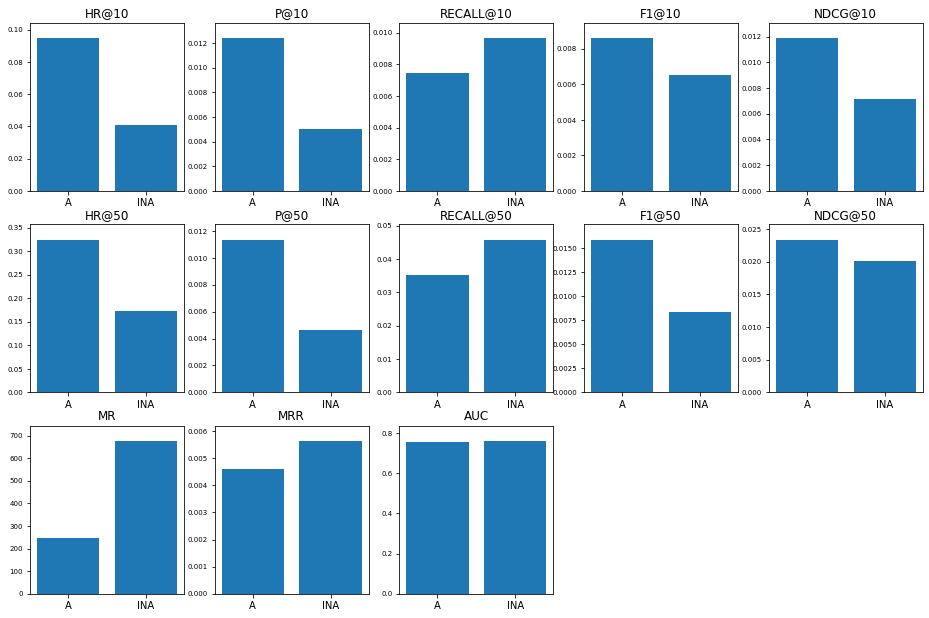

In [65]:
group_labels = {"user_group_activity": {"A": "active" , "INA": "inactive"}} if group_name == "user_group_activity" else {}
plot_fairness({group_name: stats}, group_name, group_labels, ncol=5)